# Leikecase: Norske namn

## Bakgrunn

SSB har datagrunnlag for [10467: Fødte, etter jentenavn og guttenavn 1880 - 2022 ](https://www.ssb.no/statbank/table/10467/)
Tabellen inneheld namn over alle personar som er folkeregisterte i Noreg.
Dersom det er mindre enn fire personar med eit namn eitt gitt år, så vil det visast som ein tom verdi i dataen.

SSB har rota mase med "Unorske" teikn, og har difor erstatta
- È med E
- É med E
- Ô med O
- ' med blank
- Ä med Æ
- Ü med Y
- Ö med Ø

Eksempelvis består 5449 ANDRE av 
- 1831 André
- 72 Andrè
- 13 Andre'

Spørsmål som kan bli besvarte:
- Trender på ulike namn over tid
- Rangering av popularitet
- Mest populære namn per år, eller namn som er endra seg mest i popularitet 

## Kode

In [200]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def get_ssb_data(p: str):
    url = "https://data.ssb.no/api/v0/no/table/10467/"
    with open(f"data/ssb_query_{p}.json") as f:
        payload = json.dumps(json.load(f))
    
    headers = {
      'Content-Type': 'application/json',
    }
    
    response = requests.request("POST", url, headers=headers, data=payload)
    return response.json()

In [10]:
def json_to_records(j):
    navneliste = list(j["dimension"]["Fornavn"]["category"]["label"].values())
    årsliste = list(j["dimension"]["Tid"]["category"]["index"].keys())

    data = []
    i = 0
    for idx_navn, navn in enumerate(navneliste):
        for idx_år, år in enumerate(årsliste):
            data.append({
                "År": år,
                "Navn": navn,
                "Fødte": j["value"][i]
            })
            i += 1

    return data

### Hent navn gutter fra SSB

In [11]:
g = get_ssb_data("gutter")
g_data = json_to_records(g)
df_g = pd.DataFrame.from_records(g_data)
df_g["Type"] = "G"
df_g.fillna(0, inplace=True)

### Hent navn for jenter fra SSB

In [15]:
j = get_ssb_data("jenter")

In [16]:
j_data = json_to_records(j)
df_j = pd.DataFrame.from_records(j_data)
df_j["Type"] = "J"
df_j.fillna(0, inplace=True)

In [122]:
df = pd.concat([df_j, df_g])
df["År"] = df["År"].astype(pd.Int64Dtype())

In [126]:
total_births = df.pivot_table("Fødte", index="År", columns="Type", aggfunc="sum")

<Axes: xlabel='År'>

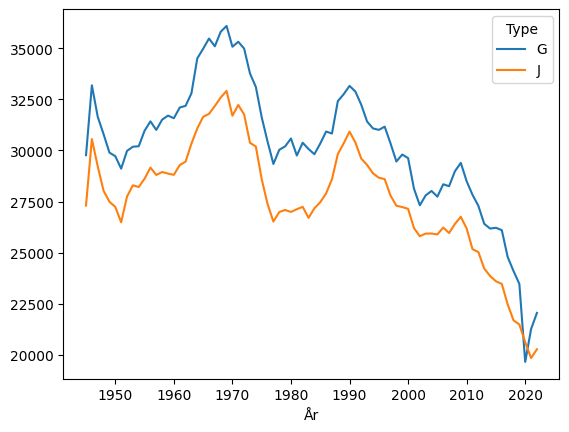

In [127]:
total_births.plot()

In [125]:
df = df[df["År"] >= 1945]

In [129]:
def add_andel(group):
    group["andel"] = group["Fødte"] / group["Fødte"].sum()
    return group

In [130]:
df = df.groupby(["År", "Type"], group_keys=False).apply(add_andel)

In [131]:
df[df["Navn"] == "Aagot"]

,År,Navn,Fødte,Type,andel
65,1945,Aagot,11.0,J,0.000403
66,1946,Aagot,5.0,J,0.000164
67,1947,Aagot,6.0,J,0.000205
68,1948,Aagot,0.0,J,0.000000
69,1949,Aagot,0.0,J,0.000000
...,...,...,...,...,...
138,2018,Aagot,0.0,J,0.000000
139,2019,Aagot,0.0,J,0.000000
140,2020,Aagot,0.0,J,0.000000
141,2021,Aagot,0.0,J,0.000000


In [132]:
df.groupby(["År", "Type"])["andel"].sum()

År    Type
1945  G       1.0
      J       1.0
1946  G       1.0
      J       1.0
1947  G       1.0
             ... 
2020  J       1.0
2021  G       1.0
      J       1.0
2022  G       1.0
      J       1.0
Name: andel, Length: 156, dtype: float64

In [144]:
def get_top100(group):
    return group.sort_values("Fødte", ascending=False)[:100]

In [148]:
top100 = df.groupby(["År", "Type"]).apply(get_top100).reset_index(drop=True)

In [149]:
top100.head()

,År,Navn,Fødte,Type,andel
0,1945,Per,1169.0,G,0.039269
1,1945,Jan,1167.0,G,0.039202
2,1945,Bjørn,1013.0,G,0.034029
3,1945,Kjell,1005.0,G,0.033760
4,1945,Svein,881.0,G,0.029595


In [155]:
total_births = top100.pivot_table("Fødte", index="År", columns="Navn", aggfunc="sum").fillna(0)
total_andel = top100.pivot_table("andel", index="År", columns="Navn", aggfunc="sum").fillna(0)

In [156]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 1945 to 2022
Columns: 631 entries, Aage to Øyvind
dtypes: float64(631)
memory usage: 385.2 KB


In [157]:
total_births.head()

Navn,Aage,Aase,Abel,Ada,Adam,Adele,Adrian,Agnes,Agnieszka,Ahmed,...,Willy,Ylva,Yngve,Åge,Åse,Åshild,Øivind,Ørjan,Øystein,Øyvind
År,,,,,,,,,,,,,,,,,,,,,
1945,74.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,0.0,0.0,125.0,304.0,0.0,119.0,0.0,133.0,161.0
1946,69.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121.0,0.0,0.0,165.0,350.0,77.0,168.0,0.0,156.0,169.0
1947,70.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,128.0,0.0,0.0,180.0,350.0,90.0,172.0,0.0,177.0,183.0
1948,73.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,114.0,0.0,0.0,169.0,305.0,70.0,143.0,0.0,195.0,153.0
1949,0.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,101.0,0.0,0.0,166.0,313.0,59.0,150.0,0.0,183.0,187.0


In [176]:
subset = total_births[["Silje", "Camilla", "Espen"]]

<Axes: xlabel='År'>

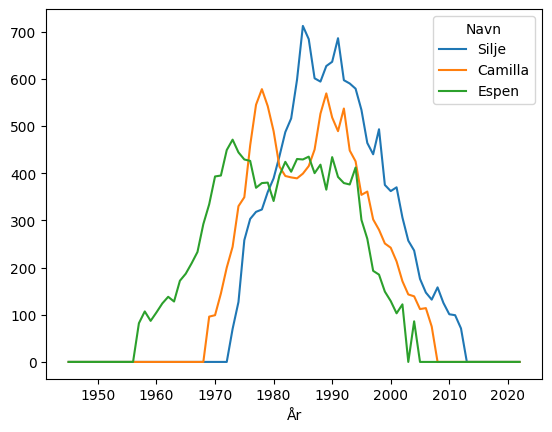

In [177]:
subset.plot() 

In [180]:
t = top100.pivot_table("andel", index="År", columns="Type", aggfunc="sum")

In [181]:
t

Type,G,J
År,,
1945,0.844973,0.816334
1946,0.843456,0.816819
1947,0.837762,0.815494
1948,0.839280,0.819269
1949,0.836701,0.812491
...,...,...
2018,0.671757,0.650219
2019,0.677121,0.663361
2020,0.686975,0.675560


<Axes: xlabel='År'>

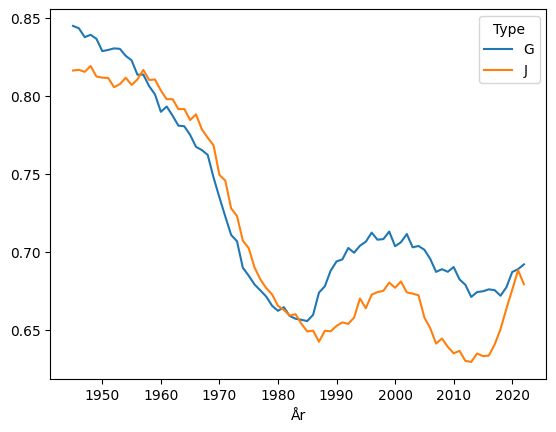

In [182]:
t.plot()

Kor mange distinkte namn i topp 50%?

In [165]:
boys = df[df["Type"] == "G"]

In [166]:
df_1950_boys = boys[boys["År"] == 1950]

In [167]:
andel_1950_boys = df_1950_boys["andel"].sort_values(ascending=False).cumsum()

In [168]:
andel_1950_boys.searchsorted(0.5) + 1

28

In [169]:
df_2022_boys = boys[boys["År"] == 2022]

In [170]:
andel_2022_boys = df_2022_boys["andel"].sort_values(ascending=False).cumsum()

In [171]:
andel_2022_boys.searchsorted(0.5) + 1

53

In [172]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values("andel", ascending=False)
    return group["andel"].cumsum().searchsorted(q) + 1

In [173]:
mangfold = df.groupby(["År", "Type"]).apply(get_quantile_count)

In [174]:
mangfold = mangfold.unstack()

<Axes: xlabel='År'>

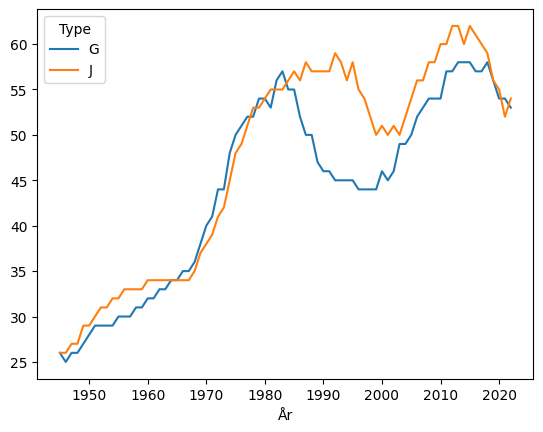

In [175]:
mangfold.plot()

## Endring over tid

In [184]:
def add_delta(group):
    group["delta"] = group["Fødte"] - group["Fødte"].shift()
    return group

In [185]:
df_delta = df.groupby(["Navn"], group_keys=False).apply(add_delta)

<Axes: xlabel='År'>

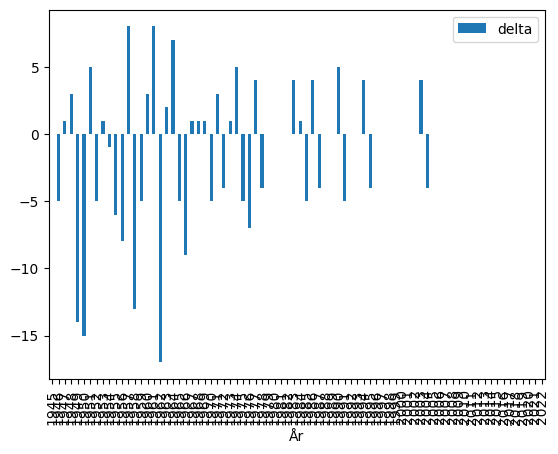

In [191]:
df_delta[df_delta["Navn"] == "Aage"].plot(x="År", y="delta", kind="bar")

## Endring i første bokstav

In [213]:
first_letters = df["Navn"].map(lambda n: n[0])
first_letters.name = "first_letter"
first_letters

65        A
65        A
66        A
66        A
67        A
         ..
143853    Å
143854    Å
143855    Å
143856    Å
143857    Å
Name: first_letter, Length: 148278, dtype: object

In [216]:
table = df.pivot_table("Fødte", index=first_letters, columns=["Type", "År"], aggfunc="sum")

In [217]:
subtable = table.reindex(columns=[1980, 2000, 2020], level="År")

In [218]:
letter_prop = subtable / subtable.sum()

<Axes: title={'center': 'J'}, xlabel='first_letter'>

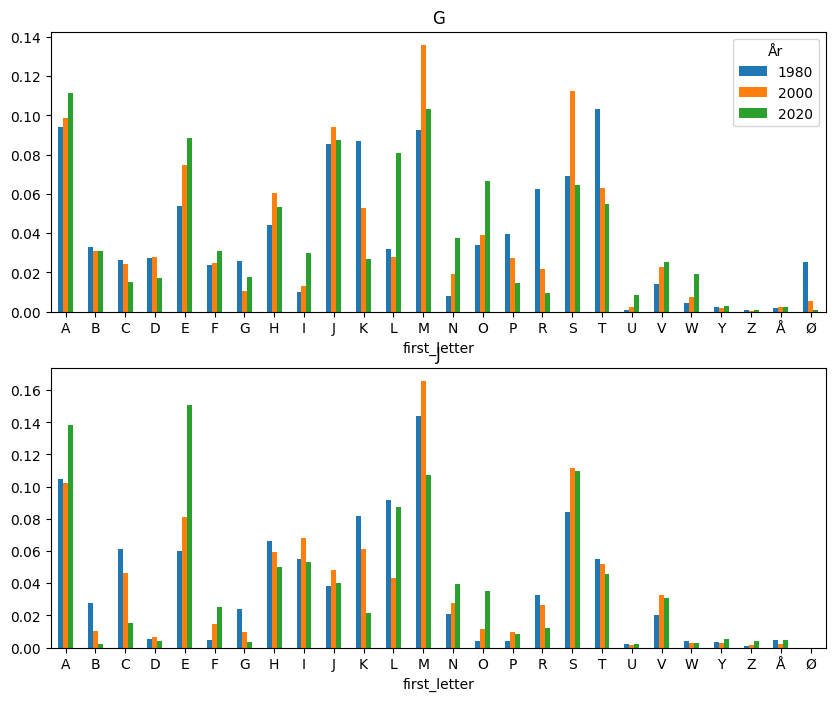

In [219]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop["G"].plot(kind="bar", rot=0, ax=axes[0], title="G")
letter_prop["J"].plot(kind="bar", rot=0, ax=axes[1], title="J",
                      legend=False)